# GPU implementation of Bfastmonitor using Python
### The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. The implementation is based on OpenCL.

### Import packages

In [1]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

# import functions from functions.py
from functions import set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [3]:
path = expanduser("~")
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [17]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    output_dir = set_output_dir(output_directory_chooser)
print(output_dir)

/home/dven/downloads/Time_series_2020-08-31_11-28-12_smallspain/0/
Output directory name: spain_small
stored_time_series/spain_small


# Load in data: if there are tiles in the directory, create a list and load per tile. The tiles and their associated data are put in the data_list object

In [18]:
# set path to dates file
data_list = set_paths(timeseries_directory = timeseries_directory)
for tile in data_list:
    print(tile)

Data consists of tiles, setting up tiles in 'data_list' 
Timeseries class holding 611 dates, sized 217 by 165.


### Check some metadata of the created Timeseries class

In [19]:
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
print("n dates in timeseries: ", data_list[0].nbands)

# Uncomment to see al vars associated with the tile
#vars(data_list[0])

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358584
n dates in timeseries:  611


# Set parameters

In [20]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=True, description='add trend', layout=Layout(height='auto', width='500px'…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [21]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0



# Select monitoring period

In [22]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7528), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-01-04', Timestamp('…

In [23]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

start_monitor = datetime(2018, 9, 14)



## Check all the parameters you set

In [24]:
data_list[0].set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend=backend,verbose=verbose,device_id=device_id)
data_list[0].get_bfast_parameters()

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x3034780>]
Monitoring starts at:  2018-09-14 00:00:00
Monitoring ends at:  2020-08-14 00:00:00
Dataset history starts at:  2000-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  True
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1


## Loop over tiles, (or single tile), in data_list
### Alternatively, if your means and breaks arrays already exist, skip this code and run load from file in the next block
### If you get a memory error, change the x_block and y_block size to a smaller power of 2: 512, 256, 128

In [25]:
# if you get a memory error, set this lower: 256, 128, 512
x_block = y_block = 256

# loading bar
with tqdm(total=len(data_list)) as pbar1:
    
    # loop over tile(s) in the data_list
    for counter, ts_data in enumerate(data_list[0:1]):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )

        ts_data.set_bfast_parameters(start_monitor = start_monitor, 
                                     end_monitor = end_monitor,
                                     start_hist = start_hist,
                                     freq = freq,
                                     k = k,
                                     hfrac = hfrac,
                                     trend = trend,
                                     level = level,
                                     backend=backend,
                                     verbose=verbose,
                                     device_id=device_id)
        
        ts_data.loop_blocks(x_block_size = x_block,
                            y_block_size=y_block)
        
        ts_data.log_all_output(output_dir_name=output_dir)
        
        pbar1.update(counter)
        
pbar1.close()

# Store the cropped dates for optional loading later
with open(output_dir + "/cropped_dates.csv","w") as f:
    for date in data_list[0].cropped_dates:
        f.write(date.strftime("%m/%d/%Y"))
        f.write("\n")

Processing tile 1 out of 1:   0%|          | 0/1 [00:00<?, ?it/s]
  0%|          | 0/0.5463409423828125 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/0.5463409423828125 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x3034780>]
rastersize:  217 165
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
start monitor:  2018-09-14 00:00:00
end monitor:  2020-08-14 00:00:00
start history:  2000-01-04 00:00:00
0 0 217 165


/usr/local/lib/python3.6/dist-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
Processing blocks of tile:: 183%|██████████| 1/0.5463409423828125 [00:07<-1:59:57,  7.95s/it]
Processing tile 1 out of 1:   0%|          | 0/1 [00:08<?, ?it/s]

--- runtime for data initialization:		0.0019724369049072266
--- runtime for data transfer (host->device):	0.009617090225219727
--- runtime for data preprocessing:		0.0028040409088134766
--- runtime for kernel execution:		0.025027751922607422
--- runtime for data transfer (device->host):	0.0009169578552246094
Fitting model over all blocks took 7.954633712768555 seconds.


## If you want to load tiles set load to True

In [15]:
load = True

if load == True:
    
    for tile in data_list:

        with open(output_dir + "/cropped_dates.csv","r") as f:
            dates_list = f.read().split('\n')
            tile.cropped_dates = [datetime.strptime(d, '%m/%d/%Y') for d in dates_list if len(d) > 0]

        tile.start_hist = tile.cropped_dates[0]
        tile.end_monitor = tile.cropped_dates[-1]
        tile.load_breaks_means_arrays_from_file(output_dir_name = output_dir)

stored_time_series/portugal_small/single_tile_means.npy
stored_time_series/portugal_small/single_tile_breaks.npy


### Check tiles for output quality

/home/dven/downloads/Time_series_2020-08-31_11-28-12_smallspain/0/tile-0000000000-0000000000/
minus2s:  0
minus1s:  25223
total 35805
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 29.55453149001536
amount of nans in means:  2296


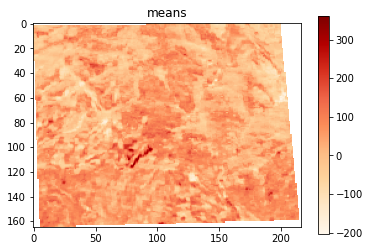

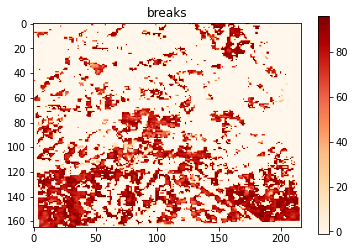

In [26]:
for tile in data_list[0:1]:
    print(tile.dir)
    
    # do some plots
    breaks = tile.breaks_array
    means = tile.means_array
    
    tile.check_arrays(min_perc_lacking_data = 50)
    
#     plt.hist(means)
#     plt.show()
    
#     im = plt.imshow(means, cmap=plt.cm.OrRd)
#     plt.colorbar(im);
#     plt.title('means')
#     plt.show()
    
#     im = plt.imshow(breaks, cmap=plt.cm.OrRd)
#     plt.colorbar(im);
#     plt.title('breaks')
#     plt.show()

    


## Merge tiles together

In [27]:
if len(data_list) > 1:
    big_means_array, big_breaks_array = merge_tiles(data_list,output_dir_name = output_dir)

# Select negative magnitudes

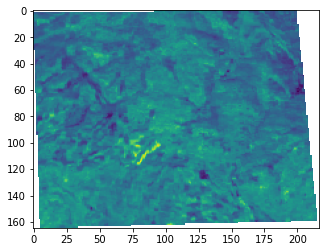

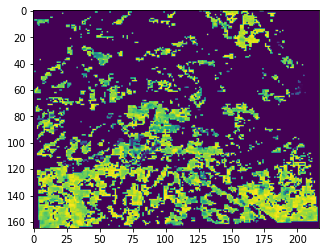

In [28]:
if len(data_list)>1:
    print("tiles")
    means = big_means_array
    breaks = big_breaks_array
else:
    means = data_list[0].means_array
    breaks = data_list[0].breaks_array

plt.imshow(means)
plt.show()
plt.imshow(breaks)
plt.show()


# norm_breaks = 1/means
#from PIL import Image
# from matplotlib import cm
# im = Image.fromarray(np.uint8(cm.rainbow(norm_breaks)*255))
# im.save("image.png")

# new_p = Image.fromarray(breaks)
# new_p = new_p.convert("RGB") #L
# new_p.save("./stored_time_series/" + output_dir + "/" + "image.png")

#im = Image.fromarray(breaks).convert('RGB')

In [ ]:
# img = Image.fromarray(breaks)
# img = img.convert("RGBA")
# datas = img.getdata()
# print(datas)

In [ ]:
# positive and negative magnitudes

#means = data_list[0].means_array
#breaks = data_list[0].breaks_array

# no_breaks_indices = (breaks == -1)
# means[no_breaks_indices] = 0

# breaks_plot = breaks.astype(np.float)
# breaks_plot[breaks == -2] = np.nan
# breaks_plot[breaks == -1] = np.nan
# #breaks_plot[means >= 0] = np.nan


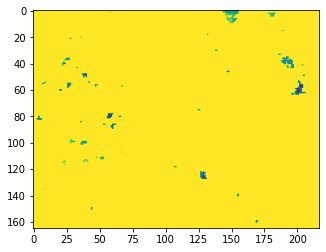

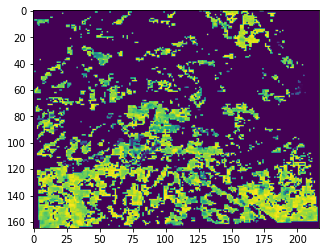

In [35]:

# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

plt.imshow(means)
plt.show()
plt.imshow(breaks)
plt.show()


In [30]:
dates_monitor = []
dates = data_list[0].cropped_dates

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [31]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
print(idx_starts)

breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        print("last")
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        print("first")
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    print("mid")

unique, counts = np.unique(breaks_plot_years, return_counts=True)
print(np.asarray((unique, counts)).T[0:10])


{2018: 0, 2019: 10, 2020: 63}
first
mid
last
[[  0.  33.]
 [  1. 103.]
 [  2. 197.]
 [ nan   1.]
 [ nan   1.]
 [ nan   1.]
 [ nan   1.]
 [ nan   1.]
 [ nan   1.]
 [ nan   1.]]


# Plot output

3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


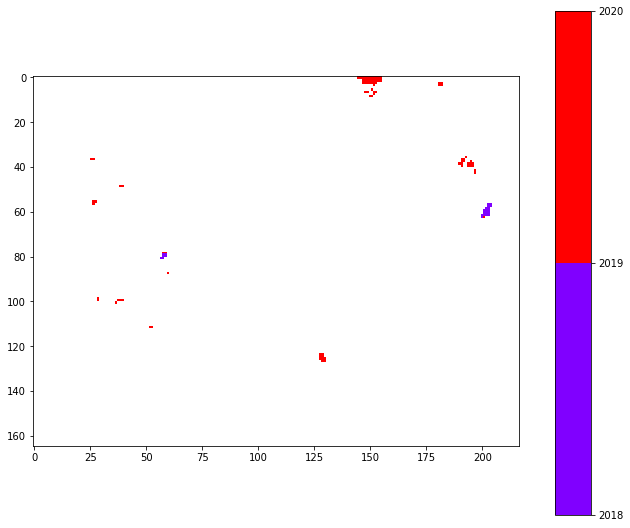

In [33]:
bins = len(idx_starts)
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
print(bins)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.show()



In [ ]:
# set corners
min_lat = data_list[0].latitude
max_lat = data_list[0].latitude
min_lon = data_list[0].longitude
max_lon = data_list[0].longitude

for x in range(len(data_list)):    
    if data_list[x].latitude < min_lat:
        min_lat = data_list[x].latitude
    if data_list[x].latitude > max_lat:
        max_lat = data_list[x].latitude + data_list[x].nrows*data_list[x].xpixelsize
    if data_list[x].longitude < min_lon:
        min_lon = data_list[x].longitude
    if data_list[x].longitude > max_lon:
        max_lon = data_list[x].longitude + data_list[x].ncols*data_list[x].ypixelsize

## But ipyleaflet does not work yet

In [ ]:
#from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker
from ipyleaflet import Map, LayersControl, ImageOverlay

m = Map(center=(max_lat, min_lon), zoom=8)
url = "stored_time_series/Guyana/image.png"

image = ImageOverlay(url = url,
                     bounds=((min_lat, min_lon), (max_lat, max_lon)))

m.add_layer(Marker(location=(max_lat, min_lon)))

control = LayersControl(position='topright')
m.add_control(control)
m.add_layer(image);

m

#m.save('my_map.html', title='My Map')


## So plotting with folium all the pixels is quite slow. 

In [ ]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [ ]:
# this is probs still wrong, maybe not though, we have to plot in a loop, maybe use ipy thing?

from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)



# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image="stored_time_series/Guyana/image.png",
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    colormap = newcmp,
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

# icon = folium.Icon(color="red", icon="ok")
# marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
# marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m

In [ ]:
print(total_cols)

In [ ]:
print(total_rows)

In [ ]:
for tile in data_list:
    print(tile.ncols)